# Plot Burden and Forcing Maps for Paper

The notebook create global maps of
* burden
* middle atmoshpere shortwave & longwave forcing

It reads timemean data for nudged and ensemble simulation and all different fire scalings.

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import cartopy.crs as ccrs
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )

import string

In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [5]:
input_dir = '~/data/wifi-aus/statistics/'

dset = xr.open_dataset( f'{input_dir}/burden-and-forcings-for.maps.nc' )

## Plotting 

In [6]:
def map_plotter(v, vmin = -3e-7, vmax = 3e-7, mode = 'fire1.0', proj = ccrs.Robinson(central_longitude=180),
                relative = False,
                ioffset = 0, cmap = plt.cm.RdBu_r, bartext = 'BC Burden / (kg m${}^{-2}$)'):

    v_ens_all = ens_stat( v )
    
    v_ens = v_ens_all.sel( mode = mode)
    v_nudged = v.sel( ensemble = 'nudged' )
    dv_nudged = v_nudged.sel( mode = mode) - v_nudged.sel( mode = 'fire0.0')
    
    if relative:
        dv_nudged = 100. * dv_nudged / v_nudged.sel( mode = 'fire0.0')
    
    fig, axs = plt.subplots(figsize = (20, 7), ncols = len( v.time ), nrows = 2, subplot_kw = dict(projection=proj),  )
    plt.subplots_adjust( left = 0.2, right = 0.9, hspace = 0.2, wspace = 0.1)
    # nudged
    i = 0
    iabc = ioffset
    for time in v.time:
        a = axs[0,i]
        p = dv_nudged.sel(time = time).plot(
            vmin = vmin, vmax = vmax,
            add_colorbar = False,
            cmap = cmap,
            ax = a, transform=ccrs.PlateCarree(),)
                    
     #   a.set_title('(%s)' % string.ascii_lowercase[iabc])
        a.set_title('(%s) %s' % (string.ascii_lowercase[iabc], str(time.data)[:7]))
            
        #p.set_global()
        a.coastlines()  
        
        i += 1
        iabc += 1
        
        
    i = 0
    for time in v.time:
        a = axs[1,i]
        vmean = v_ens.sel(time = time, stats = 'mean')
        vconf = v_ens.sel(time = time, stats = 'confidence')
        vref  = v_ens.sel(time = time, stats = 'reference',) 
        
        sigma = np.abs( vmean / vconf )
        
        if relative:
            vmean = 100*vmean / vref

        p = vmean.plot(
            vmin = vmin, vmax = vmax,
            add_colorbar = False,
            cmap = cmap,
            ax = a, transform=ccrs.PlateCarree(),)
        
        if i == 0:
            axc = fig.add_axes( [0.92, 0.2, 0.01, 0.6] ) 
            plt.colorbar(p, axc)
            plt.figtext( 0.97, 0.5, bartext,  rotation = 90, va = 'center', ha = 'center', fontsize = 'x-large' )

        sigma.where(sigma > 1).plot.contourf( 
            ax = a,
            levels = [0, 1000],
            add_colorbar = False,
            transform=ccrs.PlateCarree(),
            colors='none', 
            hatches = ['//'])

        a.set_title('(%s) %s' % (string.ascii_lowercase[iabc], str(time.data)[:7]))
            
        #p.set_global()
        a.coastlines()  
        
        i += 1
        iabc += 1
        
    fkws = dict(ha = 'right', fontsize = 20, fontweight = 'bold')
    plt.figtext(0.18, 0.7, 'nudged', **fkws)
    plt.figtext(0.18, 0.3, 'ensemble', **fkws)
    plt.figtext(0.55, 0.95, bartext, ha = 'center', fontsize = 24, fontweight = 'bold' )
    
    return 

        

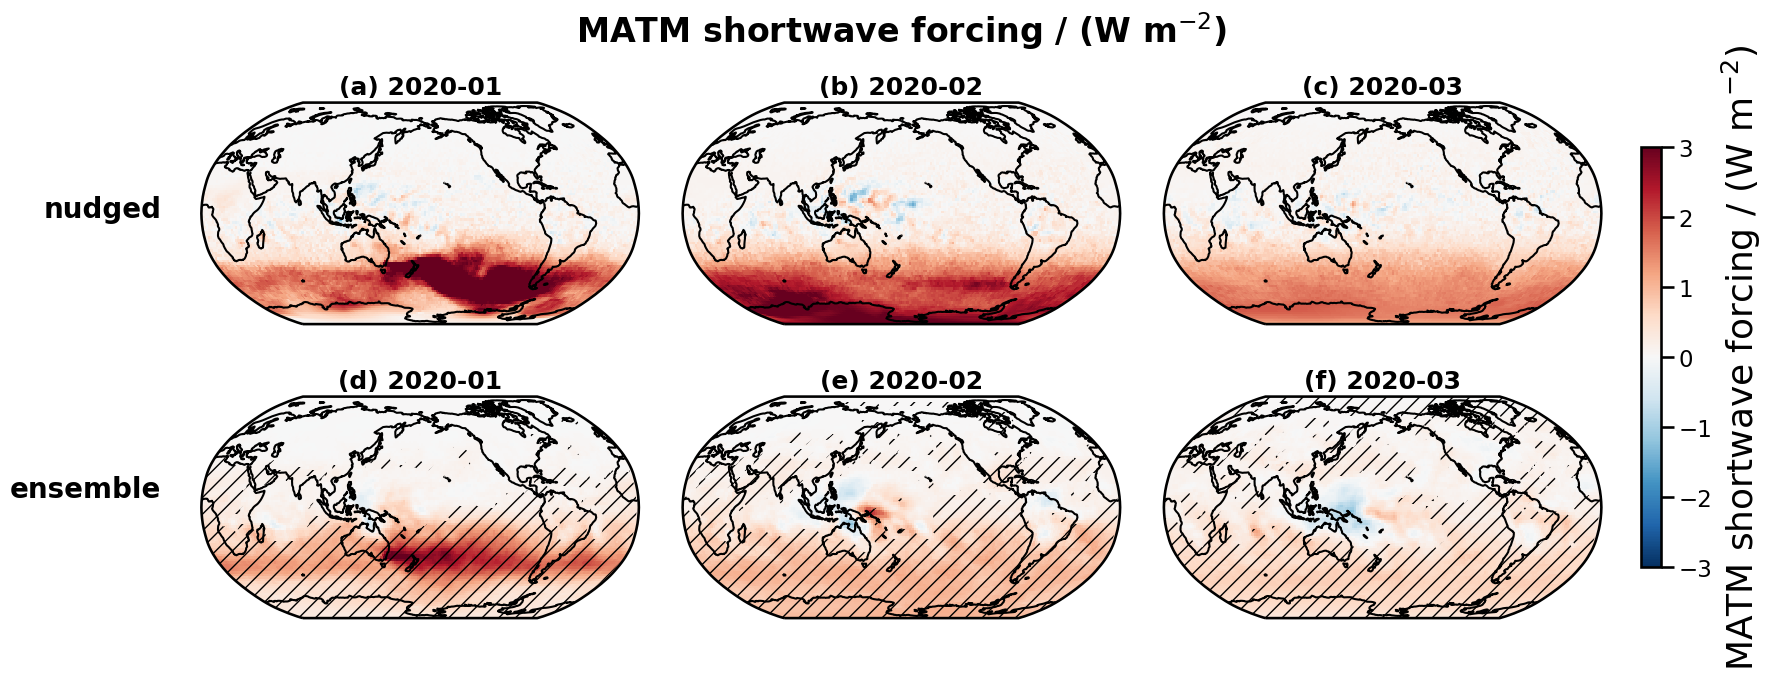

In [7]:
kws = dict( vmin = -3, vmax = 3, ioffset = 0, bartext = 'MATM shortwave forcing / (W m${}^{-2}$)' )
map_plotter( dset['F_sw_MA'], **kws )
plt.savefig('../pics/sw-ma-forcing-maps.png', dpi = 600)

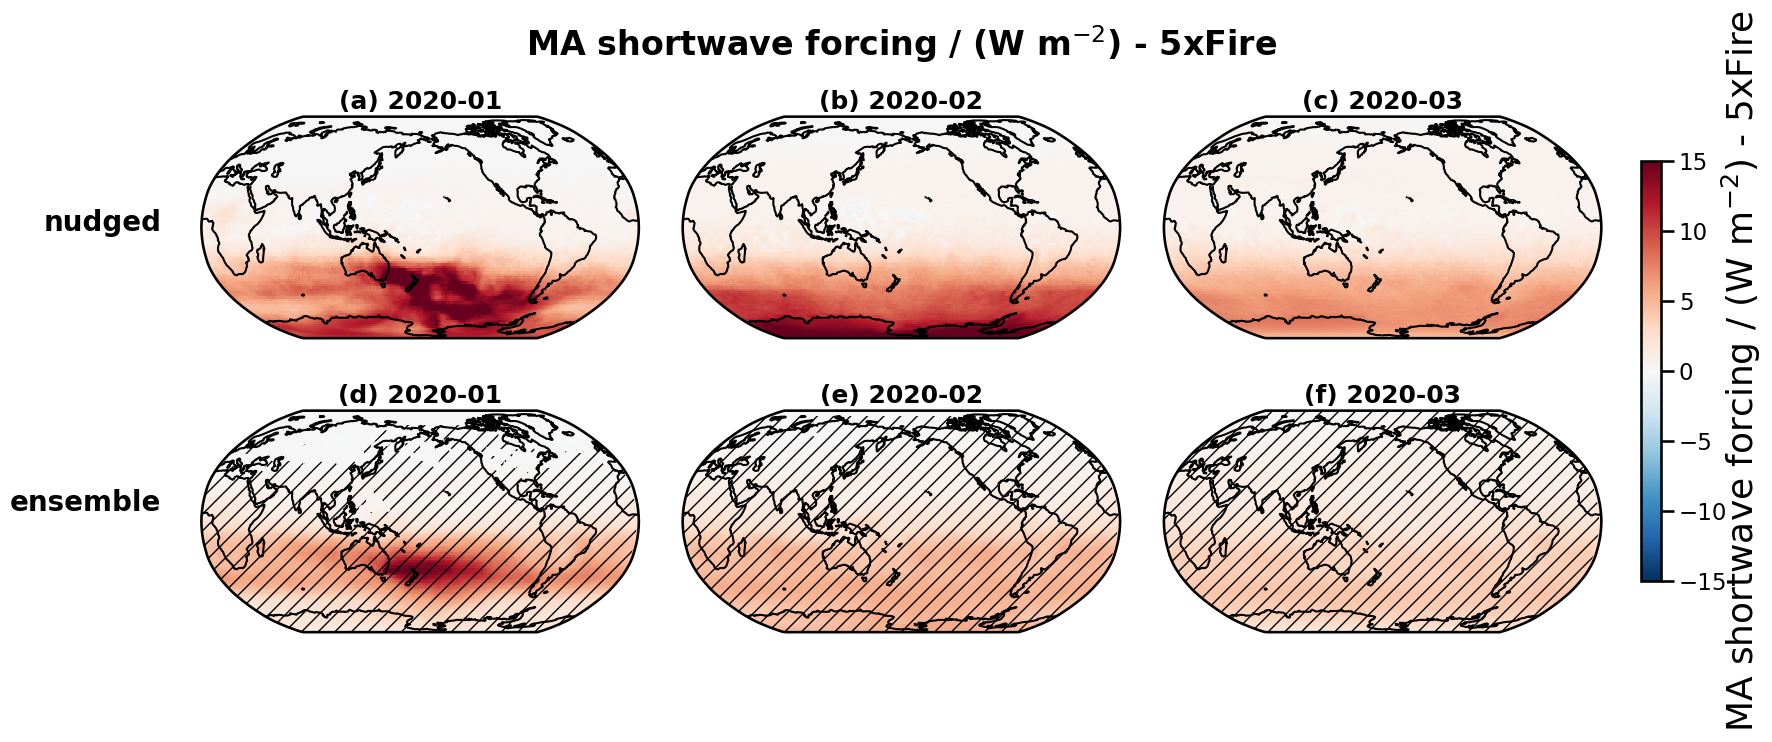

In [8]:
kws = dict( vmin = -3*5, vmax = 3*5, ioffset = 0, mode = 'fire5.0',
            bartext = 'MA shortwave forcing / (W m${}^{-2}$) - 5xFire' )
map_plotter( dset['F_sw_MA'], **kws )


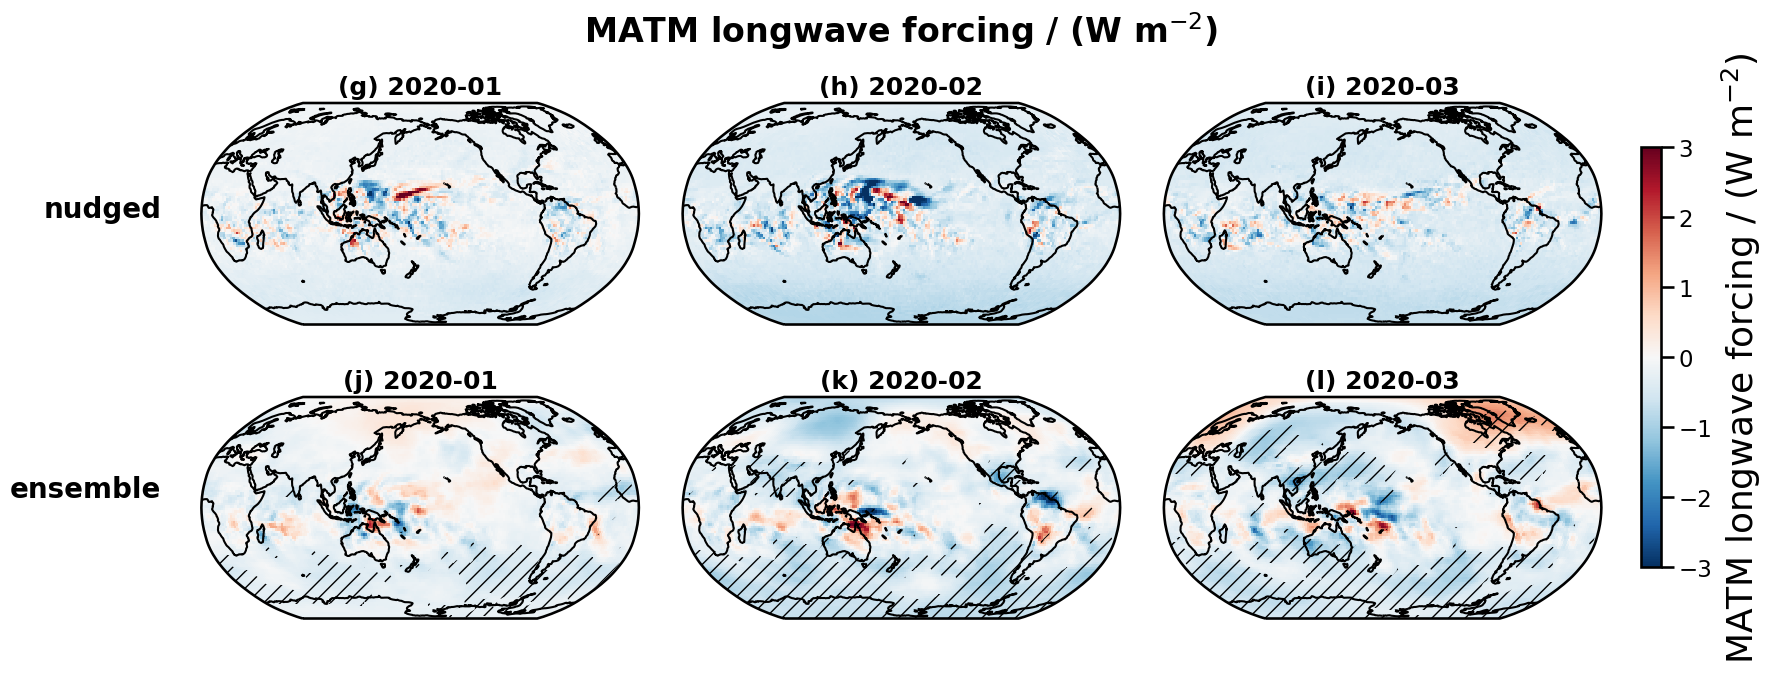

In [9]:
kws = dict( vmin = -3, vmax = 3, ioffset = 6, bartext = 'MATM longwave forcing / (W m${}^{-2}$)' )
map_plotter( dset['F_lw_MA'], **kws )
plt.savefig('../pics/lw-ma-forcing-maps.png', dpi = 600)

**Take-away points:**

* Australian smoke leads to significant positive shortwave forcing in the stratosphere.
* SW forcing is larger when actual meterological situation during wild events is considered. It is also plausible that smoke-induced synopic-scale vortex structures are efficient to keep the smoke bubble intact and in a rather confined shape.
* Stratospheric thermal structure adjusts such that a negative longwave response balances a significant portion of the shortwave forcing. The longwave response is most significant in the region where the smoke-radiation interaction happens. 
